In [1]:
import torch
import json
import numpy as np
import pandas as pd
from pathlib import Path
# from h5py import File

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
# custom libraries
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../../spaths'))
print(f"{sys.executable = }")

from src import nets
from src.systems import rqp4_dat
import sf_nets.models as models
import sf_nets.datasets as datasets
from utils.mpl_utils import set_figsize

plt.style.use("../utils/research_note.mplstyle")

sys.executable = '/Users/pzielinski/opt/anaconda3/envs/py38/bin/python'


In [4]:
root = Path('..')

In [138]:
path = root / f'results/models/rqp4/'
series_list = []
for file in os.listdir(path):
    fpath = Path(file)
    if fpath.suffix == '.pt':
        train_data = torch.load(path / fpath.name)
        par_dict = {
            key:val
            for key, val in train_data['info']['config'].items()
            if key in {'max_epochs', 'batch_size', 'burst_dt', 'burst_size'}
        }
#         par_dict['layers (i,l,[h])'] = train_data['state']['best_model_dict'].keys()
        par_dict['train_size'] = train_data['info']['config']['loader']['train_size']
        par_dict['valid_size'] = train_data['info']['config']['loader']['valid_size']
        par_dict['features'] = train_data['info'].get('features', [])
#         par_dict['sparsity'] = train_data['best'].get('sparsity', 0)
        pruning = train_data['info']['config'].get('pruning')
        if pruning:
            par_dict['sparsity'] = pruning['target_sparsity']
        else:
            par_dict['sparsity'] = 0.0
        par_dict['valid_loss'] = train_data['history']['valid_losses'][train_data['best']['epoch']-1]
        par_dict['model_id'] = fpath.stem
        series_list.append(par_dict)
models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
models_df.set_index('model_id').sort_values(by='model_id').style.format({
    'sparsity': '{0:.0%}',
    'valid_loss': '{:.2}',
    'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
    'burst_dt': '{:.0e}',
    'burst_size': '{:.0e}'
})

,max_epochs,batch_size,burst_dt,burst_size,train_size,valid_size,features,sparsity,valid_loss
model_id,,,,,,,,,
pruned_0,35,16,4e-03,1e+04,6238,2673,"[4, 8, 4, 1, 4, 8, 4]",70%,0.95
pruned_1,350,16,4e-03,1e+04,6238,2673,"[4, 32, 16, 1, 16, 32, 4]",70%,0.82
pruned_2,350,16,4e-03,1e+04,6238,2673,"[4, 32, 32, 1, 32, 32, 4]",80%,0.82
pruned_3,350,16,4e-03,1e+04,6238,2673,"[4, 32, 32, 1, 32, 32, 4]",90%,0.74
simple_0,30,16,4e-03,1e+04,6238,2673,"[4, 8, 4, 1, 4, 8, 4]",0%,0.99
simple_1,200,16,4e-03,1e+04,6238,2673,"[4, 16, 1, 16, 4]",0%,0.81
simple_6,250,16,4e-03,1e+04,6238,2673,"[4, 32, 16, 1, 16, 32, 4]",0%,0.45
test_l1,200,16,4e-03,1e+04,6238,2673,"[4, 12, 4, 1, 4, 12, 4]",0%,0.17
test_mse,400,16,4e-03,1e+04,6238,2673,"[4, 12, 4, 1, 4, 12, 4]",0%,0.033


In [139]:
# print(models_df.sort_values(by='model_id').to_latex(
#     index = False,
#     columns = ['model_id', 'max_epochs', 'features', 'sparsity', 'valid_loss'],
#     header = ['Model id', 'Max epochs', 'Architecture', 'Sparsity', 'Loss'],
#     formatters = {
#         'sparsity': lambda x: f'{x:.0%}',
# #         'valid_loss': '{:.2}',
# #         'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
# #         'burst_dt': '{:.0e}',
# #         'burst_size': '{:.0e}'
#     }
# ))

In [140]:
# path = f'../results/models/rqp4_bckp/'
# series_list = []
# for file in os.listdir(path):
#     fpath = Path(file)
#     if fpath.suffix == '.pt':
#         train_data = torch.load(path + fpath.name)
#         par_dict = {
#             key:val
#             for key, val in train_data['config'].items()
#             if key not in {'valid_split', 'loader', 'pruning', 'layers_to_prune', 'target_sparsity'}
#         }
# #         par_dict['layers (i,l,[h])'] = train_data['state']['best_model_dict'].keys()
#         par_dict['train_size'] = train_data['config']['loader']['train_size']
#         par_dict['valid_size'] = train_data['config']['loader']['valid_size']
#         par_dict['features'] = train_data['state'].get('features', [])
#         par_dict['sparsity'] = train_data['state'].get('sparsity', 0)
#         par_dict['valid_loss'] = train_data['history']['valid_losses'][train_data['state']['best_epoch']-1]
#         par_dict['model_id'] = fpath.name
#         series_list.append(par_dict)
# models_df = pd.DataFrame(series_list)
# models_df.set_index('model_id').sort_values(by='model_id')
# models_df.sort_values(by='model_id').style.format({
#     'sparsity': '{0:.0%}',
#     'valid_loss': '{:.2}',
#     'features': lambda x: "{:}".format(list(x)),  # TODO: format with dashes
#     'burst_dt': '{:.0e}',
#     'burst_size': '{:.0e}'
# }).hide_index()

## Plot loss for every epoch

In [161]:
model_id = 'test_l1'

In [162]:
train_data = torch.load(f'../results/models/RQP4/{model_id}.pt')
config = json.load(open(f'../configs/RQP4/{model_id}.json'))
print(f'{train_data.keys() = }')

train_data.keys() = dict_keys(['id', 'info', 'best', 'history'])


In [163]:
train_losses = train_data['history']['train_losses']
valid_losses = train_data['history']['valid_losses']
checkpoints = train_data['history']['checkpoints']
epochs = range(1, train_data['info']['config']['max_epochs']+1)
best_epoch = train_data['best']['epoch']

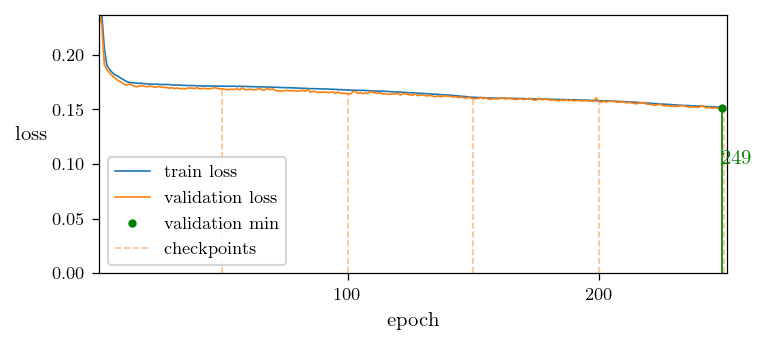

In [164]:
fig, ax = plt.subplots(figsize=set_figsize(textwidth_fraction=0.9, height_to_width_ratio=0.46))

ax.plot(epochs, train_losses, label="train loss")
loss_line, = ax.plot(epochs, valid_losses, label="validation loss")
loss_color = loss_line.get_color()

# regular checkpoints
check_ids = [check_id for check_id, check_type in checkpoints if check_type != 'best']
check_loss = [valid_losses[idx-1] for idx in check_ids]
plt.vlines(x=check_ids, ymin=0, ymax=check_loss, ls='--', color=loss_color, alpha=0.5, label='checkpoints')

# smallest validation loss / "best" model
plt.vlines(x=best_epoch, ymin=0, ymax=valid_losses[best_epoch-1], color='g')
ax.plot(best_epoch, valid_losses[best_epoch-1], 'o', color='g', label='validation min', markersize=3)

ax.text(best_epoch, .1, f'{best_epoch}', rotation=0, color='g')

ax.set_xlim([epochs[0], epochs[-1]+1])
ax.set_ylim([0.0, train_losses[1]])
ax.set_xticks(check_ids[1::2])
ax.set_xlabel("epoch")
ax.set_ylabel("loss", rotation=0, labelpad=10)
ax.legend()

fig.tight_layout()
fig.savefig(root / f"results/figs/{model_id}_loss.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

In [165]:
model = models.SimpleAutoencoder(**train_data['info']['arguments'])
model_dict = 'model_dict'

In [166]:
def remove_mask(model_dict):
    mask_state_dict = dict(filter(lambda elem: elem[0].endswith('_mask'), model_dict.items()))
    orig_state_dict = dict(filter(lambda elem: elem[0].endswith('_orig'), model_dict.items()))
    rest = dict(filter(lambda elem: elem[0].endswith(('weight', 'bias')), model_dict.items()))
    state_dict = {
        key.replace('_orig',''): val_orig * val_mask
        for (key, val_orig), val_mask in zip(orig_state_dict.items(), mask_state_dict.values())
    }
    return {**state_dict, **rest}

In [167]:
check_epoch = 'best'

In [168]:
if check_epoch == 'best':
    state_dict = remove_mask(train_data['best']['model_dict'])
    check_epoch = best_epoch
else:
    check_dict = torch.load(f'../results/models/RQP4/{model_id}/state_at_{check_epoch}.pt')
    state_dict = remove_mask(check_dict['model_dict'])
model.load_state_dict(state_dict)

<All keys matched successfully>

In [169]:
model.eval()

SimpleAutoencoder(
  (encoder): Sequential(
    (enc_lay0): Linear(in_features=4, out_features=12, bias=True)
    (enc_act0): Sigmoid()
    (enc_lay1): Linear(in_features=12, out_features=4, bias=True)
    (enc_act1): Sigmoid()
    (enc_lay2): Linear(in_features=4, out_features=1, bias=False)
  )
  (decoder): Sequential(
    (dec_lay2): Linear(in_features=1, out_features=4, bias=False)
    (dec_act1): Sigmoid()
    (dec_lay1): Linear(in_features=4, out_features=12, bias=True)
    (dec_act0): Sigmoid()
    (dec_lay0): Linear(in_features=12, out_features=4, bias=True)
  )
)

In [170]:
names, params = zip(*[name.split('.') for name in dict(model.encoder.named_parameters()).keys()])
names, params

(('enc_lay0', 'enc_lay0', 'enc_lay1', 'enc_lay1', 'enc_lay2'),
 ('weight', 'bias', 'weight', 'bias', 'weight'))

In [171]:
from itertools import chain
named_modules = dict(chain(model.encoder.named_modules(),
                      model.decoder.named_modules()))
named_modules

{'': Sequential(
   (dec_lay2): Linear(in_features=1, out_features=4, bias=False)
   (dec_act1): Sigmoid()
   (dec_lay1): Linear(in_features=4, out_features=12, bias=True)
   (dec_act0): Sigmoid()
   (dec_lay0): Linear(in_features=12, out_features=4, bias=True)
 ),
 'enc_lay0': Linear(in_features=4, out_features=12, bias=True),
 'enc_act0': Sigmoid(),
 'enc_lay1': Linear(in_features=12, out_features=4, bias=True),
 'enc_act1': Sigmoid(),
 'enc_lay2': Linear(in_features=4, out_features=1, bias=False),
 'dec_lay2': Linear(in_features=1, out_features=4, bias=False),
 'dec_act1': Sigmoid(),
 'dec_lay1': Linear(in_features=4, out_features=12, bias=True),
 'dec_act0': Sigmoid(),
 'dec_lay0': Linear(in_features=12, out_features=4, bias=True)}

In [172]:
mpl.rcParams['text.usetex'] = False
if 'pruned' in model_id:
    par_dict = {}
    for coder_name, coder in model.named_children():
        for name, par in coder.named_parameters():
            mat = par.detach().numpy()
            if mat.ndim == 1:
                mat = mat[:, np.newaxis]
            layer_name, par_name = name.split('.')
            value = par_dict.setdefault(layer_name, [])

            value.append((name, mat.T))

    ncols = len(par_dict)
    import matplotlib.gridspec as gridspec
    fig = plt.figure(constrained_layout=True, figsize=(9, 2.5))

    gs = fig.add_gridspec(2, ncols)
    clim = (0, 1)
    # plt.setp(axs, xticks=[], yticks=[])
    for n, (layer_name, par_list) in enumerate(par_dict.items()):
        if len(par_list) == 1:
            ax = fig.add_subplot(gs[0,n])
            ax.imshow(np.absolute(par_list[0][1])>0, clim=clim)
            ax.set_title(par_list[0][0])
        else:
    #         gap = -np.ones((2, par_list[0][1].shape[1]))
    #         mat = np.vstack((par_list[0][1], gap, par_list[1][1]))
            ax_w = fig.add_subplot(gs[0,n])
            ax_w.imshow(np.absolute(par_list[0][1])>0)
            ax_w.set_title(par_list[0][0])
            ax_b = fig.add_subplot(gs[1,n], sharex=ax_w)
            ax_b.imshow(np.absolute(par_list[1][1])>0)
            ax_b.set_title(par_list[1][0])

    all_axes = fig.get_axes()
    plt.setp(all_axes, xticks=[], yticks=[])
    
    fig.savefig(root / f"results/figs/{model_id}_wmats.pdf", dpi=300)
    plt.show(fig)
    plt.close(fig)
mpl.rcParams['text.usetex'] = True

In [173]:
train_dataset = datasets.RQP4("../data")
test_dataset = datasets.RQP4("../data", train=False)

In [174]:
#train_dataset = torch.utils.data.Subset(train_dataset, range(par_dict['train_size']))
# valid_dataset = torch.utils.data.Subset(train_dataset, range(train_data['params']['valid_nsam']))
train_test_ds = [train_dataset, test_dataset]

In [175]:
# train_coords = np.array([point.numpy() for point, _ in train_dataset]).T
# valid_coords = np.array([point.numpy() for point, _ in valid_dataset]).T
# slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in train_dataset]).T
# slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in valid_dataset]).T

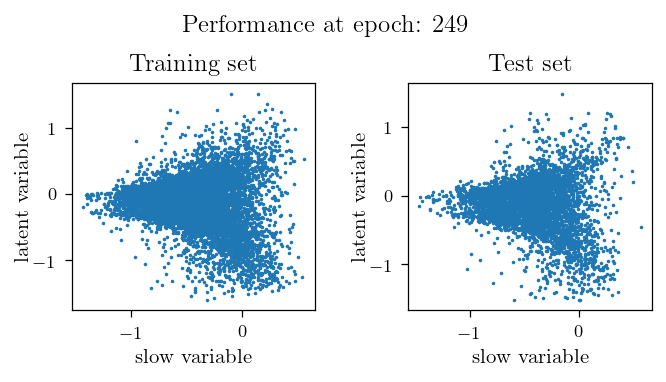

In [176]:
fig, axs = plt.subplots(ncols=2, figsize=set_figsize(textwidth_fraction=0.8, height_to_width_ratio=0.55))

for ax, ds, title in zip(axs, train_test_ds, ['Training set', 'Test set']):
    slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in ds]).T
    ax.scatter(slow_var, lat_var, s=.5)
    
    ax.set_title(f'{title}')
    ax.set_ylabel('latent variable', labelpad=0)
    ax.set_xlabel('slow variable')

fig.tight_layout()

fig.suptitle(f'Performance at epoch: {check_epoch}')
fig.subplots_adjust(top=0.8)
fig.savefig(root / f"results/figs/{model_id}_slowvar.pdf", dpi=300)
plt.show(fig)
plt.close(fig)

In [177]:
data = np.array([point.detach().numpy() for point, covi in train_dataset])
rec_var = np.array([model(point)[0].detach().numpy() for point, covi in train_dataset])
print(f'{data.shape = }')
rec_var.shape

data.shape = (8911, 4)


(8911, 4)

In [178]:
rec_data = model(torch.from_numpy(data))[0].detach().numpy()
rec_data.shape

(8911, 4)

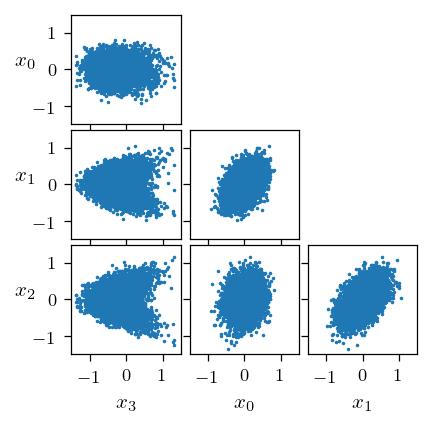

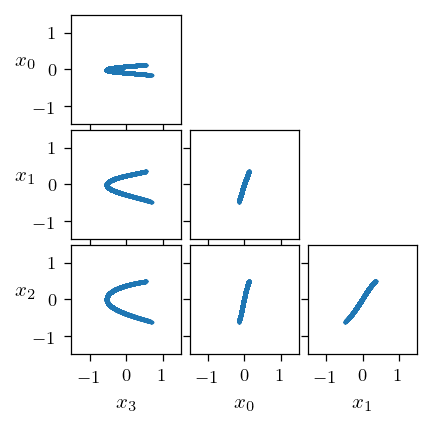

In [179]:
fig = plt.figure(figsize=(3,3))
gs = GridSpec(3, 3, figure=fig, hspace=0.05, wspace=0.05)

for n, coord in enumerate(data.T[:-1]):
    for m in range(n+1):
        ax = fig.add_subplot(gs[n, m])
#         ax.set_title(f"{n}, {m-1}")
        ax.scatter(data[:,m-1], coord, s=0.5)
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_aspect("equal")
        if n == 2:
            ax.set_xlabel(f"$x_{(m-1) % 4}$")
#             ax.set_xticks([-.25, 0.0, +.25])
        else:
            ax.set_xticklabels([])
        if m == 0:
            ax.set_ylabel(f"$x_{n}$", rotation=0)
#             ax.set_yticks([-.25, 0.0, +.25])
        else:
            ax.set_yticklabels([])

plt.show(fig)
plt.close(fig)
fig = plt.figure(figsize=(3,3))
gs = GridSpec(3, 3, figure=fig, hspace=0.05, wspace=0.05)

for n, coord in enumerate(rec_data.T[:-1]):
    for m in range(n+1):
        ax = fig.add_subplot(gs[n, m])
#         ax.set_title(f"{n}, {m-1}")
        ax.scatter(rec_data[:,m-1], coord, s=0.5)
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_aspect("equal")
        if n == 2:
            ax.set_xlabel(f"$x_{(m-1) % 4}$")
#             ax.set_xticks([-.25, 0.0, +.25])
        else:
            ax.set_xticklabels([])
        if m == 0:
            ax.set_ylabel(f"$x_{n}$", rotation=0)
#             ax.set_yticks([-.25, 0.0, +.25])
        else:
            ax.set_yticklabels([])

plt.show(fig)
plt.close(fig)

In [137]:
import torch
import torch.nn as nn
mse = nn.MSELoss()
data_t = torch.Tensor(data)
rec_data_t = torch.Tensor(rec_data)
np.sqrt(mse(data_t, rec_data_t))

tensor(0.1825)

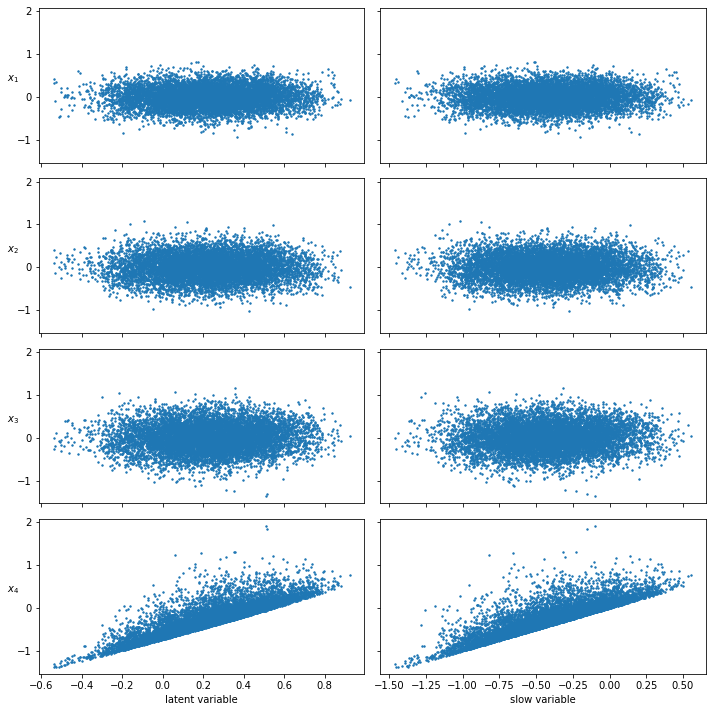

In [89]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=True, sharex='col')

coords = np.array([point.numpy() for point, _ in train_dataset]).T
slow_var, lat_var = np.array([(rqp4_dat['smap'](point), model(point)[1].item()) for point, covi in train_dataset]).T

for n, ax_row in enumerate(axs):
    ax_row[0].scatter(lat_var, coords[n], s=2)
    ax_row[1].scatter(slow_var, coords[n], s=2)
    ax_row[0].set_ylabel(f'$x_{n+1}$', rotation=0)

ax_row[0].set_xlabel('latent variable')
ax_row[1].set_xlabel('slow variable')

fig.tight_layout()
plt.show()
plt.close(fig)